In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import fetch_data_from_db

In [2]:
query = "SELECT * FROM xdr_data"
df = fetch_data_from_db(query)

In [3]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


# Task 3.1
### Aggregate the number of xDR sessions, session duration and the total download (DL) and upload (UL) data for each application

In [4]:
# Aggregate the engagement metrics per customer id (MSISDN)
df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
engagement_metrics = df.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'Dur. (ms)': 'sum', 'Total Traffic (Bytes)': 'sum'})
engagement_metrics.columns = ['Session Frequency', 'Session Duration', 'Total Traffic']


#### Top 10 customers per engagement metric

In [5]:

# Report the top 10 customers per engagement metric
top_10_customers = engagement_metrics.nlargest(10, ['Session Frequency', 'Session Duration', 'Total Traffic'])

# print the top 10 customers per engagement metric
top_10_customers

,Session Frequency,Session Duration,Total Traffic
MSISDN/Number,,,
3.362632e+10,18,8791927.0,7.971167e+09
3.362578e+10,17,18553754.0,8.499621e+09
3.361489e+10,17,9966898.0,8.846226e+09
3.365973e+10,16,4035428.0,7.705863e+09
3.376054e+10,15,9279434.0,8.514774e+09
3.367588e+10,15,4865947.0,7.891111e+09
3.366716e+10,13,8744914.0,5.618394e+09
3.360313e+10,12,6287761.0,4.976195e+09
3.376041e+10,12,5321667.0,7.132371e+09


### Normalize the engagement metrics and run a k-means (k=3) to classify customers in three groups of engagement

In [6]:

# Normalize each engagement metric
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics)

# Run a k-means (k=3) to classify customers in three groups of engagement
kmeans = KMeans(n_clusters=3, random_state=0).fit(normalized_metrics)


### Compute the minimum, maximum, average & total non-normalized metrics for each cluster

In [7]:

# Compute the minimum, maximum, average & total non-normalized metrics for each cluster
cluster_metrics = engagement_metrics.groupby(kmeans.labels_).agg(['min', 'max', 'mean', 'sum'])


### Aggregate user total traffic per application

In [8]:

# Aggregate user total traffic per application
applications = ['Social Media', 'Youtube', 'Netflix', 'Google', 'Email', 'Gaming', 'Other']
for app in applications:
    df[f'{app} Total Traffic (Bytes)'] = df[f'{app} DL (Bytes)'] + df[f'{app} UL (Bytes)']
app_traffic = df.groupby('MSISDN/Number')[[f'{app} Total Traffic (Bytes)' for app in applications]].sum()


#### Top 10 users per application

In [9]:

# Derive the top 10 most engaged users per application
top_10_users_per_app = app_traffic.apply(lambda x: x.nlargest(10).index.tolist())


### Plot the top 3 most used applications

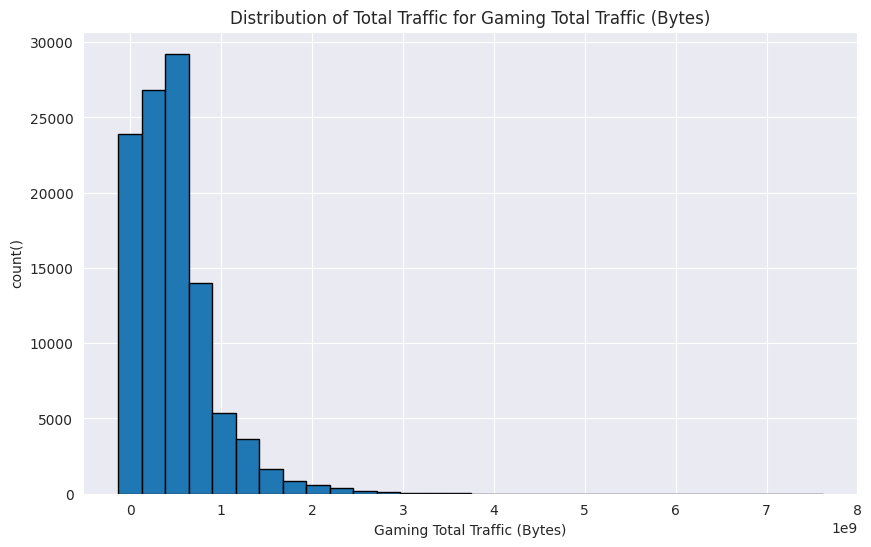

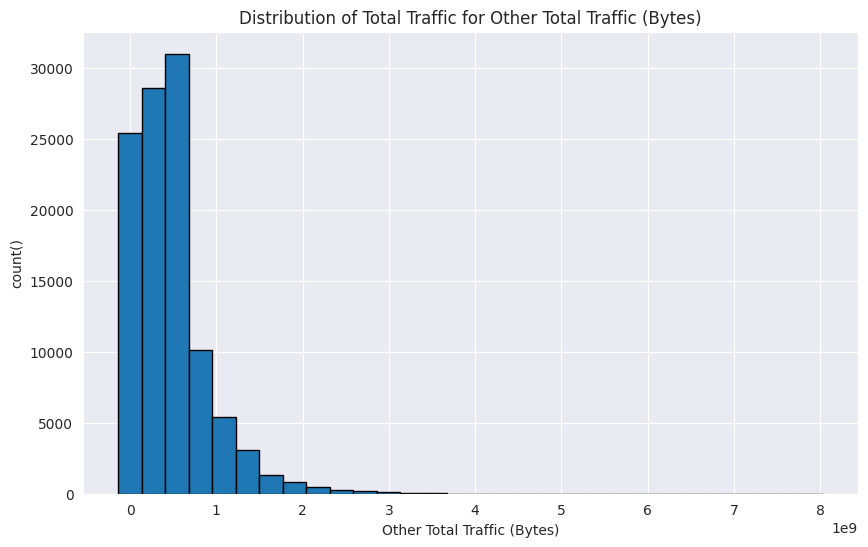

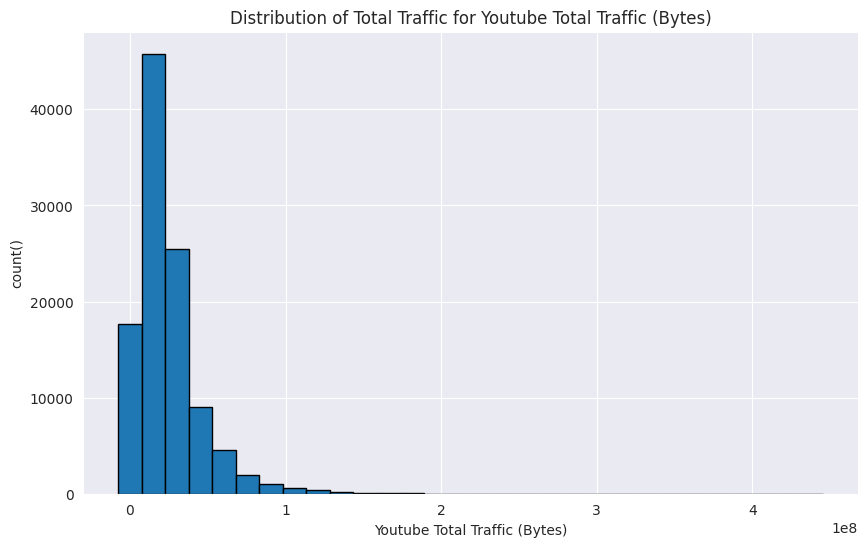

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the top 3 most used applications
top_3_apps = app_traffic.sum().nlargest(3).index

for app in top_3_apps:
    # Prepare the data
    data = app_traffic[app]
    counts, bins = np.histogram(data, bins=30)
    
    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), edgecolor='black')
    
    # Set the title and labels
    plt.title(f'Distribution of Total Traffic for {app}')
    plt.xlabel(app)
    plt.ylabel('count()')
    
    # Display the chart
    plt.show()

### Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 
1. What is the optimized value of k (use elbow method for this)?  


In [12]:
# Run a k-means (k=3) to classify customers in three groups of engagement
kmeans = KMeans(n_clusters=3, random_state=0).fit(normalized_metrics)

#### Visualize the distribution of the normalized metric before using k-means

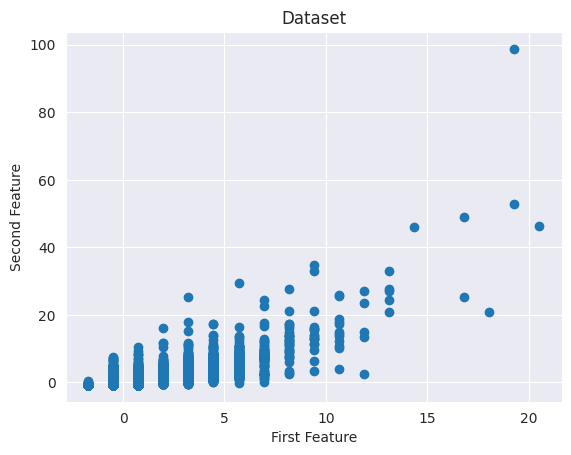

In [15]:
import matplotlib.pyplot as plt

# Assuming normalized_metrics is your data and it has two features
x1 = normalized_metrics[:, 0]  # First feature
x2 = normalized_metrics[:, 1]  # Second feature

# Visualizing the data
plt.scatter(x1, x2)
plt.title('Dataset')
plt.xlabel('First Feature')
plt.ylabel('Second Feature')
plt.show()

#### The elbow method
- WCSS - It is defined as the sum of square distances between the centroids and
each points.
- Now For determining the best number of clusters(k) we plot a graph of k versus their WCSS value. 
- Surprisingly the graph looks like an elbow. (See from the graph)
- Also, When k=1 the WCSS has the highest value but with increasing k value WCSS value starts to decrease.
- We choose that value of k from where the graph starts to look like a straight line.

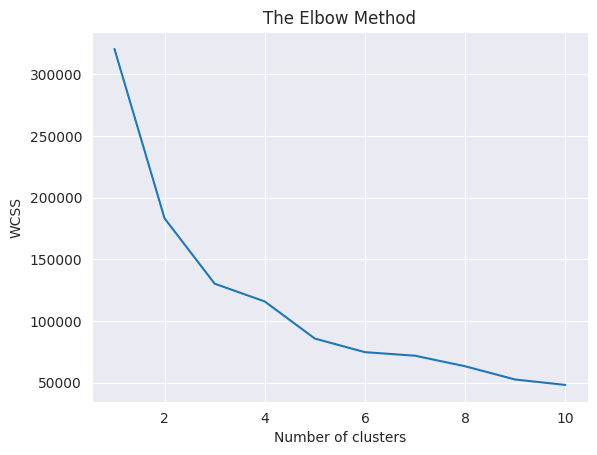

In [14]:

# Find the optimized value of k using the elbow method
# WCSS - defined as the sum of square distances between the centroids and each points.
wcss = []
for i in range(1, 11):
    # “init” argument is the method for initializing the centroid
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(normalized_metrics)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

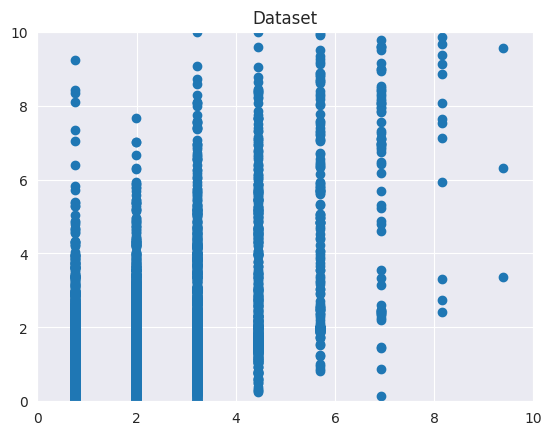

1 : 0.9056526308115298
2 : 0.6596101820187982
3 : 0.4326920729384103
4 : 0.4097766116295033
5 : 0.40563048387927425
6 : 0.3795442992501451
7 : 0.2996221259926552
8 : 0.292885019698292
9 : 0.25493644439322977


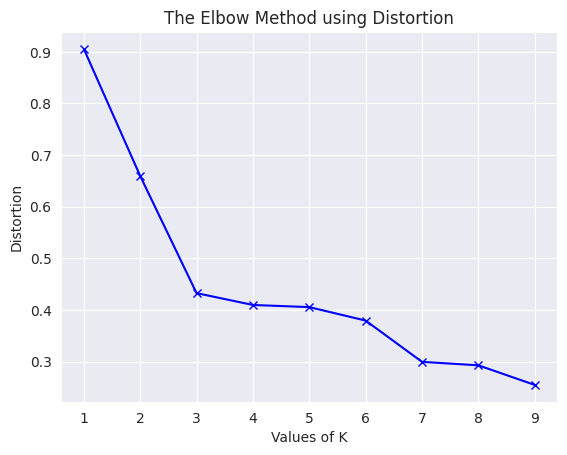

1 : 213712.00000000268
2 : 121316.657346257
3 : 86507.39671050623
4 : 58893.816976345784
5 : 51505.92920429193
6 : 39953.65300457585
7 : 33774.09098236582
8 : 28455.37217357904
9 : 24591.753719954868


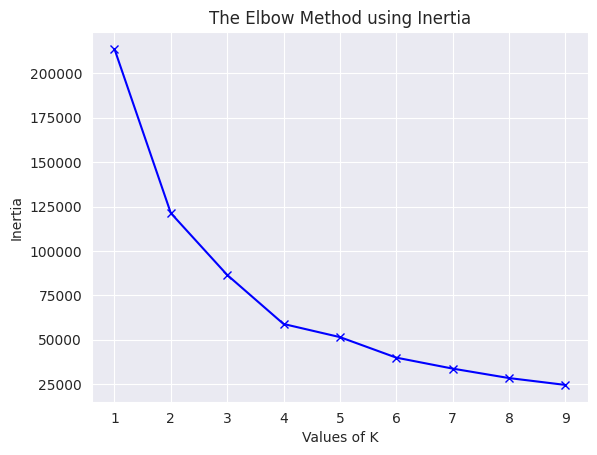

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Assuming normalized_metrics is your data and it has two features
x1 = normalized_metrics[:, 0]  # First feature
x2 = normalized_metrics[:, 1]  # Second feature
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)

# Visualizing the data
plt.plot()
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.scatter(x1, x2)
plt.show()

# Building the clustering model and calculating the values of the Distortion and Inertia
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

# Using the different values of Distortion
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# Using the different values of Inertia
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()